In [1]:
!pip3 install -q --upgrade --user git+https://github.com/pymc-devs/pymc4.git

# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [3]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal(mu=0., sigma=1, name='mu_alpha')
    sigma_a = yield pm.HalfCauchy(beta=1, name='sigma_alpha')
    mu_b = yield pm.Normal(mu=0., sigma=1, name='mu_beta')
    sigma_b = yield pm.HalfCauchy(beta=1, name='sigma_beta')

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal(mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()),
                        name='alpha')
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal(mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()),
                        name='beta')

    # Model error
    eps = yield pm.HalfCauchy(beta=1, name='eps')

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal(mu=radon_est, sigma=eps, observed=data.log_radon, name='y_like')

### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [4]:
def sample(model, init_num_chains=50, num_samples=500, burn_in=500):
    init_num_chains = 50
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)
    for i in range(3):
        step_size_ = []
        for _, x in pm4_trace.items():
            std = tf.math.reduce_std(x, axis=[0, 1])
            step_size_.append(
                std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
        pm4_trace, _ = pm.inference.sampling.sample(
            model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
            step_size=step_size_, xla=True)
        
    num_chains = 5
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

    pm4_trace, sample_stat = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=num_samples, burn_in=burn_in,
        step_size=step_size_, xla=True)
    
    az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)
    
    return az_trace

In [5]:
model = hierarchical_model(data, county_idx)
az_trace = sample(model)

In [6]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.727928, 0.787003, 0.698101, 0.736407, 0.001975], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

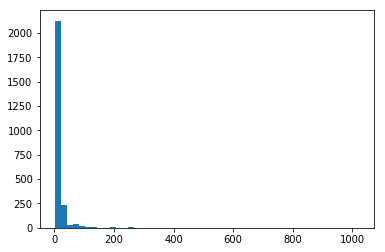

In [7]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [8]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/beta[0],-0.606,0.243,-1.037,-0.061,0.006,0.004,1688.0,1688.0,1785.0,634.0,1.46
hierarchical_model/beta[1],-0.743,0.219,-1.213,-0.374,0.026,0.019,73.0,66.0,114.0,660.0,1.08
hierarchical_model/beta[2],-0.633,0.226,-1.104,-0.188,0.005,0.004,2060.0,1884.0,2119.0,918.0,1.44
hierarchical_model/beta[3],-0.666,0.214,-1.161,-0.286,0.005,0.005,1809.0,993.0,1737.0,588.0,1.44
hierarchical_model/beta[4],-0.611,0.246,-1.072,-0.098,0.006,0.004,1696.0,1696.0,2015.0,428.0,1.44
hierarchical_model/beta[5],-0.633,0.268,-1.177,-0.099,0.006,0.004,1780.0,1780.0,1963.0,471.0,1.45
hierarchical_model/beta[6],-0.472,0.277,-0.897,0.132,0.044,0.031,40.0,40.0,48.0,587.0,1.08
hierarchical_model/beta[7],-0.620,0.217,-1.019,-0.139,0.005,0.004,1740.0,1740.0,1900.0,894.0,1.44
hierarchical_model/beta[8],-0.522,0.273,-0.976,0.056,0.027,0.019,102.0,102.0,132.0,663.0,1.13
hierarchical_model/beta[9],-0.700,0.211,-1.120,-0.293,0.005,0.005,2087.0,776.0,2091.0,711.0,1.46


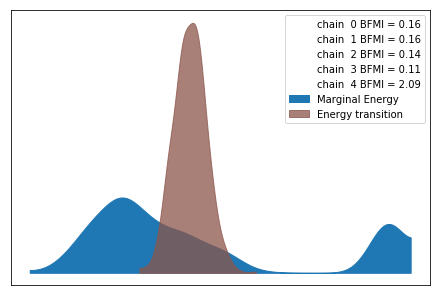

In [9]:
az.plot_energy(az_trace);

/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anaconda3/lib/python3.6/site-packages/arviz/plots/kdeplot.py:326: RuntimeWarning: invalid value encountered in true_divide
  density /= norm_factor
/Users/twiecki/anacond

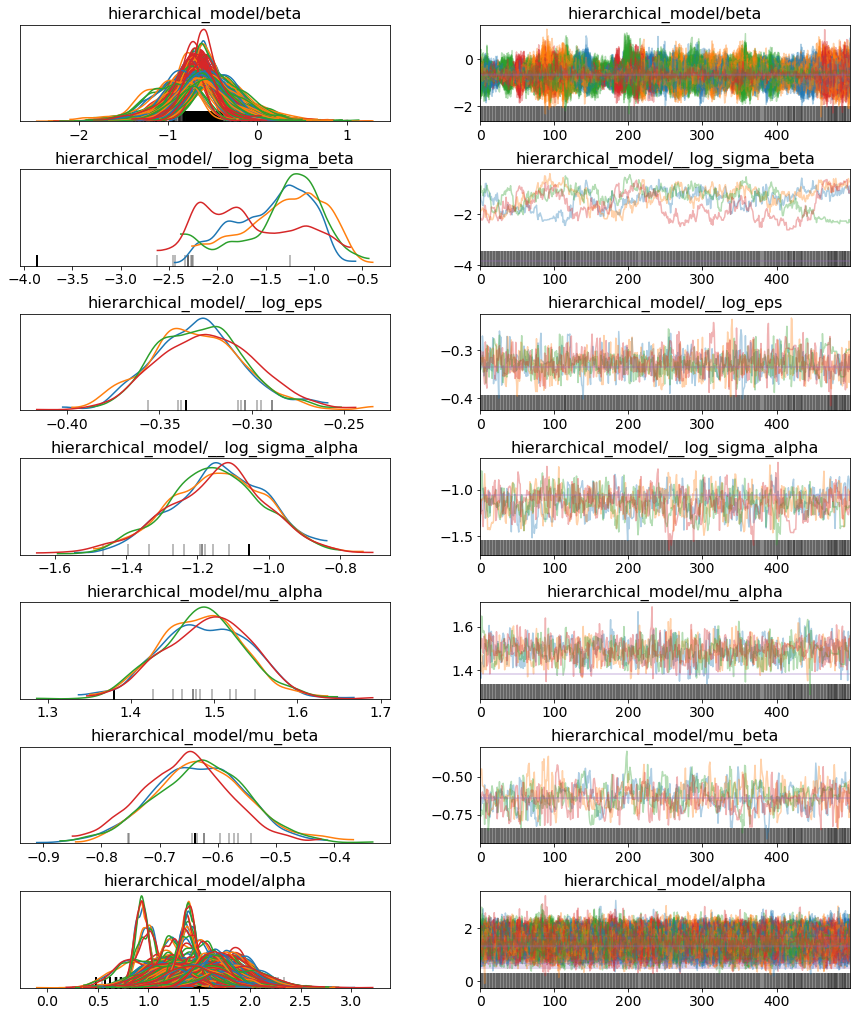

In [10]:
az.plot_trace(az_trace, compact=True);

## Models are just distributions

In [16]:
@pm.model
def Hierarchical(n, centered=True):
    mu = yield pm.Normal(mu=0., sigma=1, name='mu')
    sigma = yield pm.HalfCauchy(beta=1, name='sigma')
    if centered:
        s = yield pm.Normal(mu=mu, sigma=sigma, 
                            plate=n, name='s')
    else:
        offset = yield pm.Normal(mu=0, sigma=1, 
                                 plate=n, name='offset')
        s = mu + sigma * offset
    return s
    
@pm.model
def hierarchical_model_nc(data, county_idx):
    n = len(data.county.unique())
    # TODO Use same name-syntax as with other RVs
    a = yield Hierarchical(n=n, centered=True, name='alpha')
    b = yield Hierarchical(n=n, centered=False, name='beta')

    # Model error
    eps = yield pm.HalfCauchy(beta=1, name='eps')

    # Expected value
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood    
    y_like = yield pm.Normal(mu=radon_est, sigma=eps, observed=data.log_radon, name='y_like')

In [17]:
model = hierarchical_model_nc(data, county_idx)
az_trace_nc = sample(model)

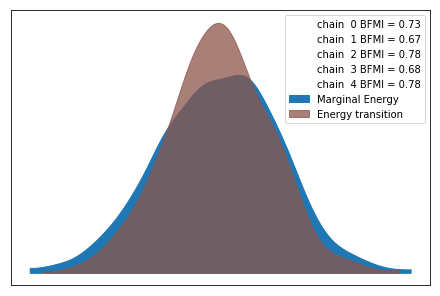

In [18]:
az.plot_energy(az_trace_nc);

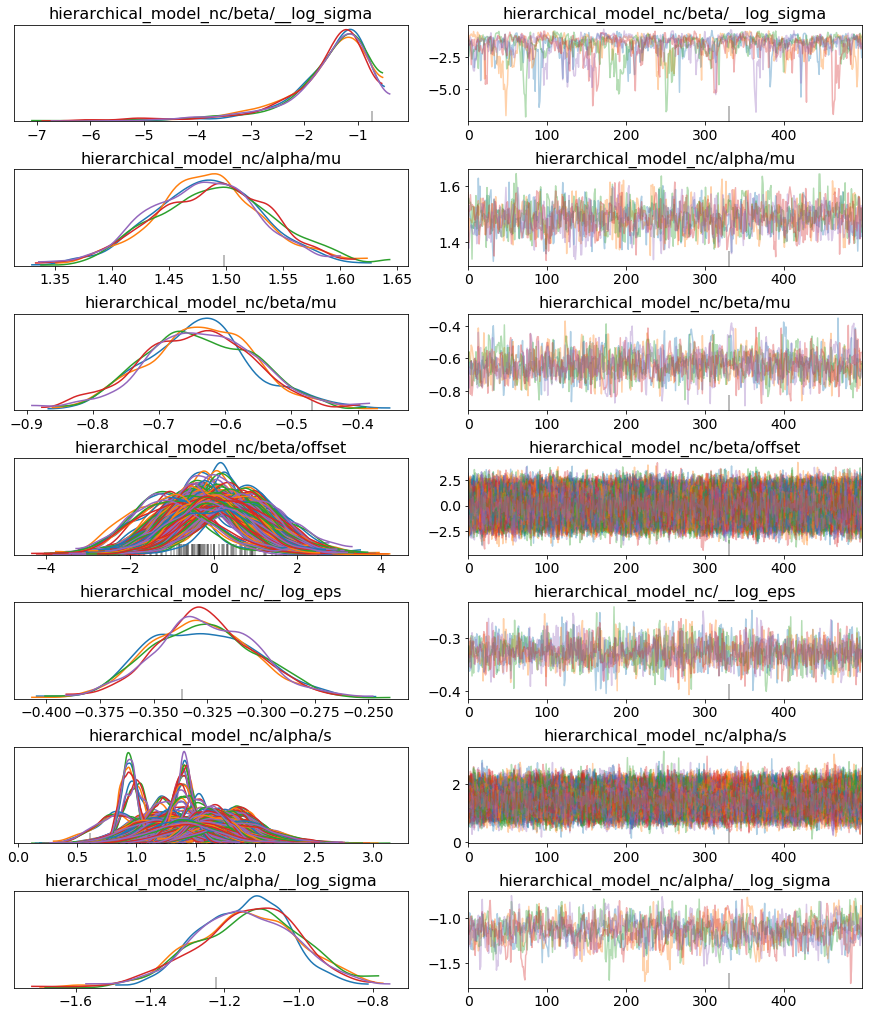

In [19]:
az.plot_trace(az_trace_nc, compact=True);